In [1]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import openml
import datetime

import matplotlib.pyplot as plt

import scipy as sp
import scipy.stats
import numpy as np
import pandas as pd
import itertools as it
from tqdm.notebook import tqdm
import pickle

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

# Preliminaries

## Read Result Data

In [2]:
dfResults = pd.read_csv("results_final.csv")
dfResults

,timeout,openmlid,seed,algorithm,metric
0,85000,1485,0,rf,0.600788
1,85000,1485,0,random,0.373946
2,85000,1590,0,rf,0.570204
3,85000,1485,0,auto-sklearn,0.288015
4,85000,1590,0,random,0.358099
...,...,...,...,...,...
3420,85000,31,7,semi-naive,0.417230
3421,85000,40975,8,semi-naive,0.014152
3422,85000,31,8,naive,0.517943
3423,85000,31,8,semi-naive,0.623437


## Compute metrics to be used for the different datasets

In [3]:
OPTIMIZERS = ["rf", "random", "auto-sklearn", "gama", "naive", "semi-naive"]
OPTIMIZER_COLORS = {"rf": "C4", "random": "C5", "auto-sklearn": "C0", "gama": "C1", "naive": "C2", "semi-naive": "C3"}
OPTIMIZER_NAMES = {"rf": "rf", "random": "random", "auto-sklearn": "auto-sklearn", "gama": "GAMA", "naive": "naive", "semi-naive": "quasi-naive"}

datasets = [int(i) for i in pd.unique(dfResults["openmlid"])]

In [4]:
with open('performancecurves.pickle', 'rb') as handle:
    performance_curves_1d = pickle.load(handle)
    
TIME_LIMIT_HOUR = 3600
TIME_LIMIT_DAY = 85000

# Main Analysis

In [5]:
def get_algos_and_times_for_curveset(curveset):
    
    # get all algorithms and times
    algos = None
    times = set([])
    for openmlid, performance_curves_of_dataset in curveset.items():
        algos_here = set(performance_curves_of_dataset.keys())
        if algos is None:
            algos = algos_here
        elif algos != algos_here:
            raise Exception("Inconsistent algorithm set! Current is " + str(algos) + " but local is " + str(algos_here))
        for curve in performance_curves_of_dataset.values():
            if not "times" in curve:
                print(f"Empty curve set for dataset {openmlid}")
                continue
            for t in curve["times"]:
                times.add(t)
                
    if algos is None:
        raise Exception(f"No algorithms observed in curveset {curveset}")
    times = sorted(list(times))
    algos = sorted(list(algos))
    return algos, times

def get_relative_curves_per_dataset(performance_curves_per_dataset, baseline, max_loss_value = 10):
    algos, times = get_algos_and_times_for_curveset(performance_curves_per_dataset)
    cur_vals_per_dataset = {openmlid: {algo: np.inf for algo in algos} for openmlid in performance_curves_per_dataset.keys()}
    
    diff_curves = {openmlid: {algo: [] for algo in algos if algo != baseline} for openmlid in performance_curves_per_dataset.keys()}
    
    for t in tqdm(times):
        for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
            
            # compute values of all curves at point of time
            cur_vals = cur_vals_per_dataset[openmlid]
            for algo in algos:
                curve = performance_curves_of_dataset[algo]
                if not "times" in curve:
                    print(f"Empty curve set for dataset {openmlid}")
                    continue
                if t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    val = min(max_loss_value, np.nanmedian(curve["values"][index_of_timestamp], axis=0))
                    if np.isnan(val):
                        val = np.inf
                    if val > cur_vals[algo]:
                        raise Exception(f"Would update value from {cur_vals[algo]} to {val}!")
                    cur_vals[algo] = val
            
            # now compare
            base_val = cur_vals[baseline]
            for algo in algos:
                if algo != baseline:
                    if base_val == np.inf:
                        if cur_vals[algo] == np.inf:
                            diff = 0
                        else:
                            diff = max_loss_value
                    else:
                        if cur_vals[algo] == np.inf:
                            diff = max_loss_value
                        else:
                            diff = cur_vals[algo] - base_val
                    diff_curves[openmlid][algo].append(diff)
    
    return {"times": times, "algos": algos, "comparisons": diff_curves}

In [6]:
diff_curves = get_relative_curves_per_dataset(performance_curves_1d, "semi-naive", max_loss_value = 5)

  0%|          | 0/18744 [00:00<?, ?it/s]

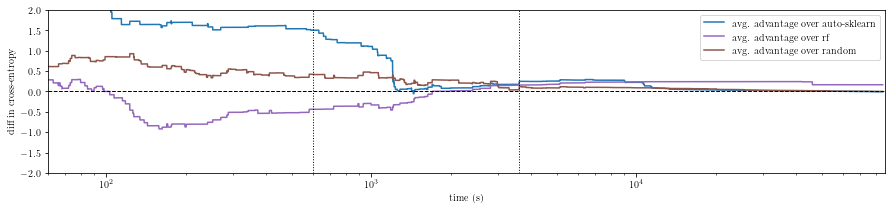

In [7]:
comparison_summary = {algo: np.mean([diff_curves["comparisons"][openmlid][algo] for openmlid in datasets if openmlid in diff_curves["comparisons"]], axis=0) for algo in diff_curves["algos"] if algo != "semi-naive"}

fig, ax = plt.subplots(figsize=(15, 3))
for comp in ["auto-sklearn", "rf", "random"]:
    ax.plot(diff_curves["times"], comparison_summary[comp], label="avg. advantage over " + comp, color=OPTIMIZER_COLORS[comp])
ax.axhline(0, linestyle="--", color="black", linewidth=1)
ax.set_xscale("log")
ax.set_xlim([60, 86400])
ax.set_ylim([-2, 2])
ax.legend()
ax.set_xlabel("time (s)")
ax.set_ylabel("diff in cross-entropy")
ax.axvline(600, linestyle="dotted", color="black", linewidth=1)
ax.axvline(3600, linestyle="dotted", color="black", linewidth=1)
fig.savefig("plots/advantages.jpg", bbox_inches='tight')
plt.show()